In [2]:
import sys
sys.path.append("..")

In [19]:
from src.config import Config, CHEST_XRAY14_CLASSES
from src.data import make_loaders
from src.model import create_model, load_checkpoint
from src.eval import infer_logits, evaluate_multilabel, sigmoid
from src.metrics import tune_threshold_for_f1
from src.calibrate import fit_temperature, apply_temperature, expected_calibration_error, brier_score, reliability_bins, plot_reliability, risk_coverage_curve
from src.uncertainty import mc_dropout_passes, tta_augment_and_predict, predictive_entropy
from src.plots import plot_bar_with_deltas, plot_risk_coverage
from src.utils import choose_worst_cases, basic_saliency, overlay_saliency_on_image

import os, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from tqdm import tqdm

print("Setting ROOT_DIR...")
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# ------------------------
# Configuration (EDIT ME)
# ------------------------
cfg = Config(
    data_dir=f"{ROOT_DIR}/data/Chest14",                   
    csv_path=f"{ROOT_DIR}/data/Chest14/Data_Entry_2017.csv",
    train_val_list=f"{ROOT_DIR}/data/Chest14/train_val_list.txt",
    test_list=f"{ROOT_DIR}/data/Chest14/test_list.txt",
    checkpoint_path=f"{ROOT_DIR}/models/densenet121.pth",
    target_classes=CHEST_XRAY14_CLASSES,
    primary_label="Pneumonia",
    img_size=224,
    batch_size=32,
    num_workers=8,
)
cfg.fix_seeds()
cfg.validate()

# Prepare output dir
os.makedirs("outputs", exist_ok=True)

print("Device:", cfg.device)
print("Target classes:", cfg.target_classes)
print("Primary label:", cfg.primary_label)

Setting ROOT_DIR...
Device: mps
Target classes: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Primary label: Pneumonia


In [20]:
# ------------------------
# DataLoaders (val/test based on Split column)
# ------------------------
train_loader, val_loader, test_loader = make_loaders(
    data_dir=cfg.data_dir,
    csv_file=cfg.csv_path,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
    seed=cfg.seed
)
print("Train batches:", len(train_loader), " Val batches:", len(val_loader), " Test batches:", len(test_loader))

Train batches: 3255  Val batches: 178  Test batches: 72



## 2. Baseline: DenseNet-121 (14-label head)
- Starts from ImageNet weights; replaces classifier with 14 outputs (sigmoid).
- (Optional) Load ChestX-ray14 pretrain checkpoint via `pretrain_ckpt_path`.

In [23]:
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights

# Load and modify the model
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 14)
model.load_state_dict(torch.load(cfg.checkpoint_path, map_location=cfg.device))
model = model.to(cfg.device)

In [24]:
from sklearn.metrics import confusion_matrix, roc_auc_score

@torch.no_grad()
def evaluate(model, loader, threshold=0.5):
    model.eval()
    probs_all, targets_all, paths_all = [], [], []
    for batch in loader:
        image, labels, img_path = batch
        image = image.to(cfg.device)
        p = torch.sigmoid(model(image)).cpu().numpy()
        probs_all.append(p)
        targets_all.append(labels.numpy())
        paths_all.extend(img_path)
    probs = np.concatenate(probs_all, axis=0)
    targets = np.concatenate(targets_all, axis=0)
    preds = (probs >= threshold).astype(np.float32)
    aurocs = {}
    for i, name in enumerate(cfg.target_classes):
        try:
            if np.unique(targets[:, i]).size > 1:
                aurocs[name] = roc_auc_score(targets[:, i], probs[:, i])
            else:
                aurocs[name] = np.nan
        except Exception:
            aurocs[name] = np.nan
    argmax_preds = probs.argmax(axis=1)
    argmax_targets = targets.argmax(axis=1)
    cm = confusion_matrix(argmax_targets, argmax_preds, labels=list(range(len(cfg.target_classes))))

    return {"probs": probs, "targets": targets, "preds": preds, "cm": cm, "paths": paths_all, "aurocs": aurocs}

results = evaluate(model, val_loader)
pd.Series(results["aurocs"]).round(3)

Atelectasis           0.817
Cardiomegaly          0.936
Consolidation         0.816
Edema                 0.879
Effusion              0.897
Emphysema             0.901
Fibrosis              0.810
Hernia                0.793
Infiltration          0.711
Mass                  0.856
Nodule                0.736
Pleural_Thickening    0.763
Pneumonia             0.771
Pneumothorax          0.822
dtype: float64

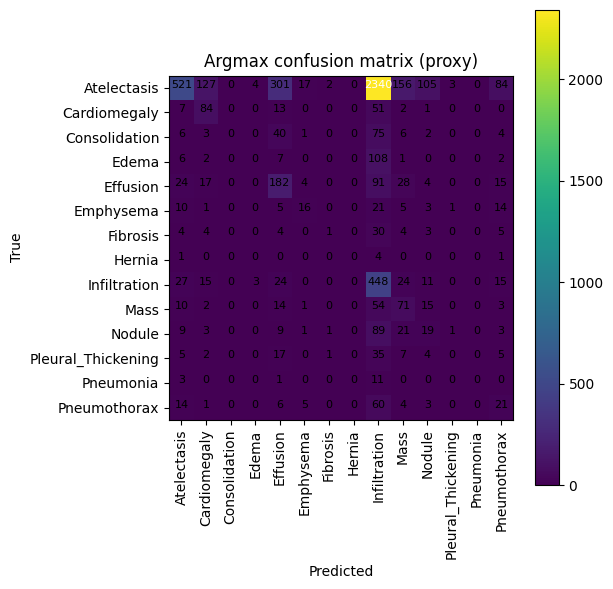

In [25]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    import itertools
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.0 if cm.size else 0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = cm[i, j]
        plt.text(j, i, f"{val:d}", ha="center",
                 color="white" if val > thresh else "black", fontsize=8)
    plt.tight_layout()
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

plot_confusion_matrix(results["cm"], cfg.target_classes, title="Argmax confusion matrix (proxy)")

In [26]:
from pathlib import Path

probs = results["probs"]; targets = results["targets"]; paths = results["paths"]
argmax_preds = probs.argmax(axis=1); argmax_targets = targets.argmax(axis=1)
max_probs = probs.max(axis=1)
fail_mask = (argmax_preds != argmax_targets) | (max_probs < 0.55)
fail_indices = np.where(fail_mask)[0]
print("Total evaluated:", len(paths), " Fail/uncertain:", len(fail_indices))

rows = []
for i in fail_indices[:50]:
    rows.append({
        "idx": int(i),
        "image_path": paths[i],
        "true_argmax": int(argmax_targets[i]),
        "pred_argmax": int(argmax_preds[i]),
        "max_prob": float(max_probs[i]),
        "suggested_dimensions": "",  # e.g., robustness; interpretability; fairness
        "notes": ""
    })
fail_df = pd.DataFrame(rows)
RESULTS_DIR = Path("./outputs")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / "failure_log.csv").write_text(fail_df.to_csv(index=False))
fail_df.head(10)

Total evaluated: 5681  Fail/uncertain: 5460


Total evaluated: 5681  Fail/uncertain: 5460


,idx,image_path,true_argmax,pred_argmax,max_prob,suggested_dimensions,notes
0,0,/Users/hasaniqbal/Documents/! PhD - MBZUAI/1st...,6,10,0.404358,,
1,1,/Users/hasaniqbal/Documents/! PhD - MBZUAI/1st...,0,10,0.092209,,
2,2,/Users/hasaniqbal/Documents/! PhD - MBZUAI/1st...,0,8,0.115566,,
3,3,/Users/hasaniqbal/Documents/! PhD - MBZUAI/1st...,0,8,0.059831,,
4,4,/Users/hasaniqbal/Documents/! PhD - MBZUAI/1st...,0,1,0.113421,,
5,5,/Users/hasaniqbal/Documents/! PhD - MBZUAI/1st...,4,4,0.156156,,
6,6,/Users/hasaniqbal/Documents/! PhD - MBZUAI/1st...,0,8,0.142081,,
7,7,/Users/hasaniqbal/Documents/! PhD - MBZUAI/1st...,0,8,0.200479,,
8,8,/Users/hasaniqbal/Documents/! PhD - MBZUAI/1st...,0,0,0.504889,,
9,9,/Users/hasaniqbal/Documents/! PhD - MBZUAI/1st...,0,8,0.042399,,


## 3. Failure mining & tagging
We flag failures where argmax prediction ≠ argmax target or max probability < 0.55.
A CSV is created for you to **tag trust dimensions** (e.g., robustness, fairness) and add notes.


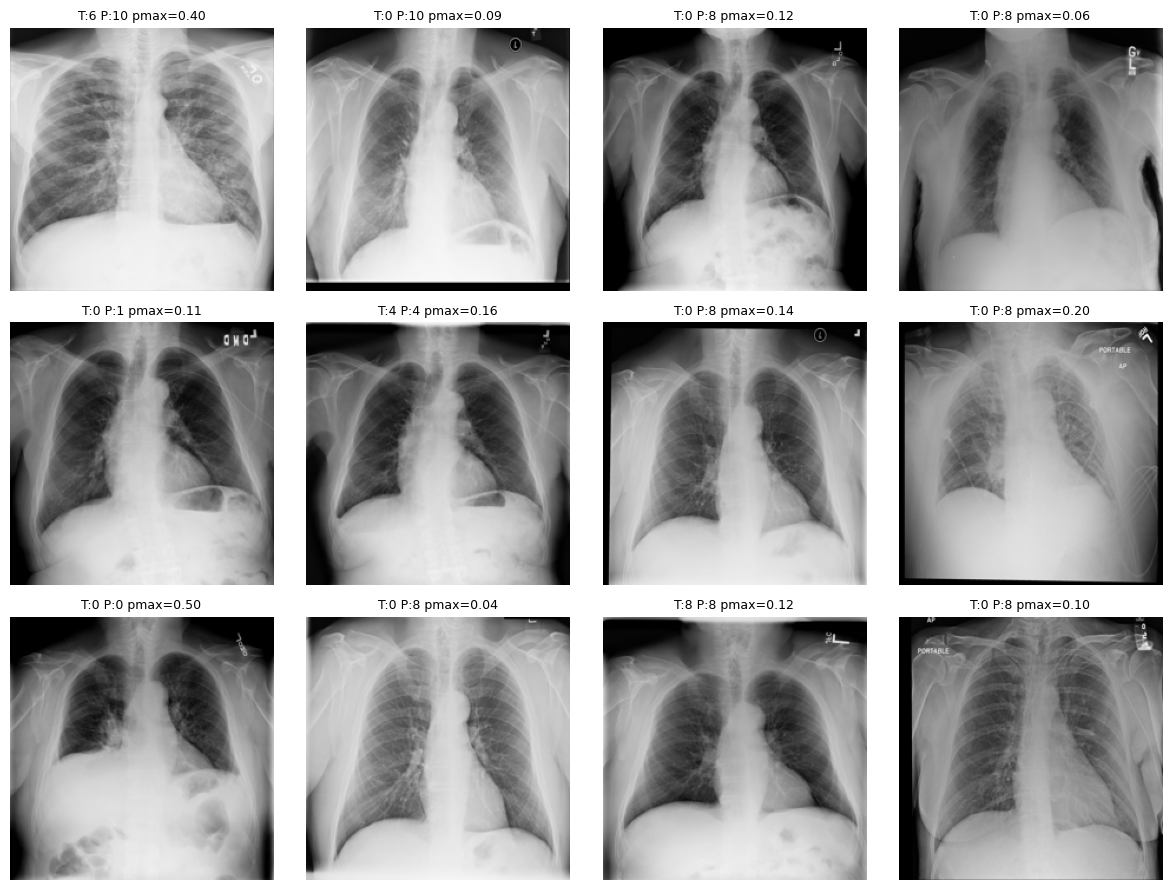

In [27]:
import math
from PIL import Image

def pil_open_safe(p):
    try:
        return Image.open(p).convert("RGB")
    except Exception:
        # placeholder if not found (FakeData case)
        arr = np.uint8(np.clip(np.random.randn(224,224,3)*40+128, 0, 255))
        return Image.fromarray(arr)

def show_failure_grid(indices, cols=4):
    indices = list(indices)
    if not indices:
        print("No failures to display.")
        return
    rows = math.ceil(len(indices)/cols)
    plt.figure(figsize=(cols*3, rows*3))
    for k, i in enumerate(indices):
        plt.subplot(rows, cols, k+1)
        img = pil_open_safe(paths[i]).resize((224,224))
        plt.imshow(img); plt.axis('off')
        t = int(argmax_targets[i]); p = int(argmax_preds[i]); mp = max_probs[i]
        plt.title(f"T:{t} P:{p} pmax={mp:.2f}", fontsize=9)
    plt.tight_layout(); plt.show()

show_failure_grid(fail_indices[:12])


## 4. Robustness stress tests
Apply simple corruptions and compare predictions vs. clean inputs. Record label flip rates.

In [28]:
from PIL import ImageFilter, ImageEnhance
import torchvision.transforms as transforms

def corrupt_image(img_pil, mode="gaussian_noise", severity=1):
    img = img_pil.copy()
    if mode == "gaussian_noise":
        np_img = np.array(img).astype(np.float32)
        sigma = 8 * severity
        noise = np.random.randn(*np_img.shape) * sigma
        np_img = np.clip(np_img + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(np_img)
    elif mode == "blur":
        return img.filter(ImageFilter.GaussianBlur(radius=1.0*severity))
    elif mode == "brightness_down":
        return ImageEnhance.Brightness(img).enhance(max(0.1, 1.0 - 0.2*severity))
    elif mode == "contrast_up":
        return ImageEnhance.Contrast(img).enhance(1.0 + 0.3*severity)
    else:
        return img

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

@torch.no_grad()
def predict_pil_list(model, imgs_pil):
    model.eval()
    xs = [transform_eval(im) for im in imgs_pil]
    x = torch.stack(xs, dim=0).to(cfg.device)
    probs = torch.sigmoid(model(x)).cpu().numpy()
    return probs

probe_idx = fail_indices[:8] if len(fail_indices) >= 8 else np.arange(min(8, len(paths)))
clean_imgs = [pil_open_safe(paths[i]).resize((224,224)) for i in probe_idx]

modes = ["gaussian_noise","blur","brightness_down","contrast_up"]
summary = []
probs_clean = predict_pil_list(model, clean_imgs)
for m in modes:
    corr_imgs = [corrupt_image(im, mode=m, severity=2) for im in clean_imgs]
    probs_corr  = predict_pil_list(model, corr_imgs)
    flip = (probs_corr.argmax(axis=1) != probs_clean.argmax(axis=1)).mean()
    summary.append({"corruption": m, "label_flip_rate": float(flip)})
robust_df = pd.DataFrame(summary)
robust_df.to_csv(RESULTS_DIR / "robustness_summary.csv", index=False)
robust_df

,corruption,label_flip_rate
0,gaussian_noise,0.875
1,blur,0.500
2,brightness_down,0.125
3,contrast_up,0.500



## 5. Interpretability — Grad-CAM (minimal)
Inspect saliency on a few failures (or random samples). If using FakeData, treat as a demonstration.


/var/folders/05/qjlfl7_s3mg827fhx6qr9l7h0000gr/T/ipykernel_15243/1952461340.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


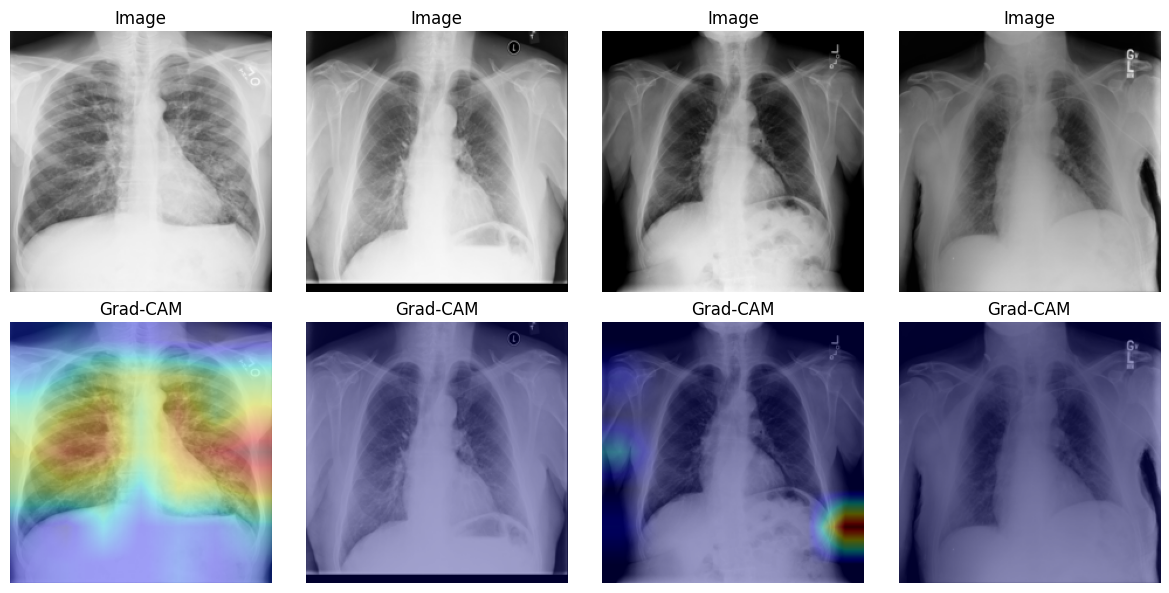

In [29]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer_name="features.denseblock4"):
        self.model = model
        self.model.eval()
        self.target_layer = dict([*model.named_modules()])[target_layer_name]
        self.activations = None
        self.gradients = None
        self.h1 = self.target_layer.register_forward_hook(self._fwd_hook)
        self.h2 = self.target_layer.register_full_backward_hook(self._bwd_hook)

    def _fwd_hook(self, m, inp, out):
        self.activations = out.detach()

    def _bwd_hook(self, m, gin, gout):
        self.gradients = gout[0].detach()

    def __call__(self, x, class_idx=None):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)
        probs = torch.sigmoid(logits)
        if class_idx is None:
            class_idx = probs.argmax(dim=1)
        target = probs[range(x.shape[0]), class_idx]
        target.backward(torch.ones_like(target))
        grads = self.gradients
        acts  = self.activations
        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * acts).sum(dim=1)
        cam = F.relu(cam)
        cams = []
        for i in range(cam.shape[0]):
            m = cam[i]
            m = (m - m.min()) / (m.max() - m.min() + 1e-6)
            cams.append(m.unsqueeze(0))
        cam = torch.stack(cams, dim=0)
        return probs.detach().cpu(), cam.detach().cpu()

    def close(self):
        self.h1.remove(); self.h2.remove()

def overlay_cam_on_image(img_pil, cam_tensor, alpha=0.35):
    cam = cam_tensor.numpy()
    cam = np.uint8(255 * cam)
    cam = Image.fromarray(cam).resize(img_pil.size, resample=Image.BILINEAR)
    import matplotlib.cm as cm
    cmap = cm.get_cmap('jet')
    heatmap = cmap(np.array(cam)/255.0)[:, :, :3]
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap_img = Image.fromarray(heatmap)
    return Image.blend(img_pil.convert("RGB"), heatmap_img, alpha=alpha)

# Run demo
probe = probe_idx[:4] if len(probe_idx)>0 else np.arange(4)
imgs = [pil_open_safe(paths[i]).resize((224,224)) for i in probe]
x = torch.stack([transforms.ToTensor()(im) for im in imgs], dim=0)
x = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(x)
x = x.to(cfg.device)

gc = GradCAM(model, target_layer_name="features.denseblock4")
probs_gc, cams = gc(x, class_idx=None)
gc.close()

plt.figure(figsize=(12,6))
for k in range(len(imgs)):
    plt.subplot(2, len(imgs), k+1); plt.imshow(imgs[k]); plt.title("Image"); plt.axis('off')
    cam_img = overlay_cam_on_image(imgs[k], cams[k,0])
    plt.subplot(2, len(imgs), len(imgs)+k+1); plt.imshow(cam_img); plt.title("Grad-CAM"); plt.axis('off')
plt.tight_layout(); plt.show()